In [1]:
# Import SparkSession dari modul PySpark SQL
# SparkSession adalah pintu masuk utama untuk menggunakan DataFrame dan library Spark SQL termasuk MLlib
# Import SparkSession untuk memulai session Spark SQL
from pyspark.sql import SparkSession

# Membuat atau mendapatkan SparkSession
# Inisialisasi builder untuk membuat SparkSession
spark = SparkSession.builder \
# Menentukan nama aplikasi Spark (terlihat di Spark UI)
    .appName("Unsupervised Learning with MLlib") \  # Menetapkan nama aplikasi Spark, akan terlihat di Spark UI
# Menyetel konfigurasi Spark, seperti jumlah memori executor
    .config("spark.executor.memory", "4g") \        # Mengalokasikan 4GB memori untuk setiap executor
# Membuat SparkSession baru atau menggunakan yang sudah ada
    .getOrCreate()                                  # Membuat SparkSession jika belum ada, atau menggunakan yang sudah ada

In [2]:
from pyspark.ml.linalg import Vectors

data = [
    (Vectors.dense([5.1, 3.5, 1.4, 0.2]),),
    (Vectors.dense([4.9, 3.0, 1.4, 0.2]),),
    (Vectors.dense([4.7, 3.2, 1.3, 0.2]),),
    (Vectors.dense([7.0, 3.2, 4.7, 1.4]),),
    (Vectors.dense([6.4, 3.2, 4.5, 1.5]),),
    (Vectors.dense([6.9, 3.1, 4.9, 1.5]),)
]

df = spark.createDataFrame(data, ["features"])

In [4]:
# Menggabungkan beberapa kolom fitur menjadi satu vektor fitur
from pyspark.ml.feature import VectorAssembler, StandardScaler


scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True)

# Melatih model machine learning terhadap DataFrame
scaled_df = scaler.fit(df).transform(df)

In [5]:
from pyspark.ml.clustering import KMeans

# Inisialisasi model KMeans untuk clustering
kmeans = KMeans().setK(3).setSeed(1)
# Melatih model machine learning terhadap DataFrame
model = kmeans.fit(scaled_df)

# Prediksi cluster
# Menggunakan model untuk memprediksi atau mengelompokkan data
predictions = model.transform(scaled_df)
# Menampilkan data dalam DataFrame
predictions.show()

+-----------------+--------------------+----------+
|         features|     scaled_features|prediction|
+-----------------+--------------------+----------+
|[5.1,3.5,1.4,0.2]|[-0.6983599143217...|         1|
|[4.9,3.0,1.4,0.2]|[-0.8888217091367...|         1|
|[4.7,3.2,1.3,0.2]|[-1.0792835039517...|         1|
|[7.0,3.2,4.7,1.4]|[1.11102713642096...|         0|
|[6.4,3.2,4.5,1.5]|[0.53964175197589...|         2|
|[6.9,3.1,4.9,1.5]|[1.01579623901345...|         0|
+-----------------+--------------------+----------+



In [7]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Within Set Sum of Squared Errors

# Dengan ini:
wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))

Silhouette with squared euclidean distance = 0.7692979876379087
Within Set Sum of Squared Errors = 0.2483333333333331


K=2, WSSSE=0.5133333333333331
K=3, WSSSE=0.2483333333333331
K=4, WSSSE=0.08000000000000008
K=5, WSSSE=0.03500000000000002
K=6, WSSSE=0.0


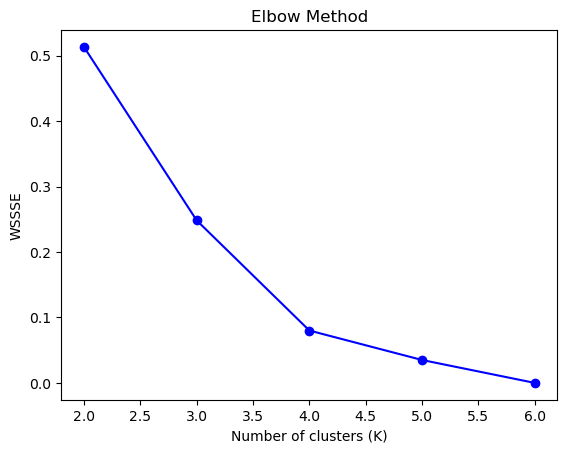

In [9]:
import matplotlib.pyplot as plt

costs = []
for k in range(2, 7):
# Inisialisasi model KMeans untuk clustering
    kmeans = KMeans().setK(k).setSeed(1)
# Melatih model machine learning terhadap DataFrame
    model = kmeans.fit(scaled_df)
    costs.append(model.summary.trainingCost)  # Gunakan trainingCost
    print(f"K={k}, WSSSE={costs[-1]}")

# Visualisasi
import matplotlib.pyplot as plt
plt.plot(range(2, 7), costs, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WSSSE')
plt.title('Elbow Method')
# Menampilkan data dalam DataFrame
plt.show()

In [10]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
# Melatih model machine learning terhadap DataFrame
pca_model = pca.fit(scaled_df)

# Transform data
# Menggunakan model untuk memprediksi atau mengelompokkan data
pca_result = pca_model.transform(scaled_df)
# Memilih kolom tertentu dari DataFrame
pca_result.select("pca_features").show(truncate=False)

+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-3.554069126484063,-5.181690130080333] |
|[-3.468384468814818,-4.750235698266647] |
|[-3.2887208403812265,-4.753062654835077]|
|[-7.550562728189456,-5.077394269765552] |
|[-7.135091699496946,-4.679675606096401] |
|[-7.701700199921557,-4.86375149478825]  |
+----------------------------------------+



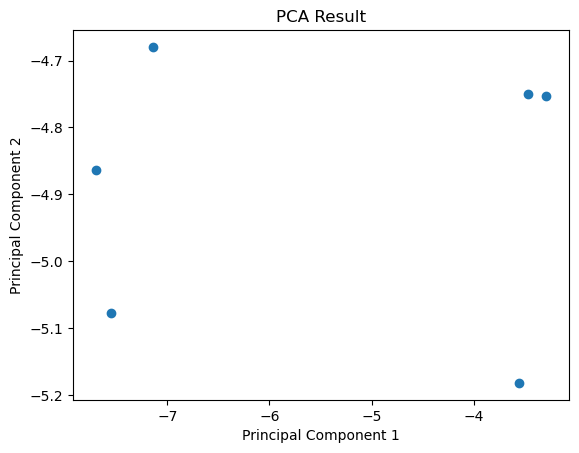

In [11]:
import numpy as np

# Ekstrak komponen utama
# Memilih kolom tertentu dari DataFrame
pca_data = pca_result.select("pca_features").rdd.map(lambda x: x[0]).collect()
x = [float(d[0]) for d in pca_data]
y = [float(d[1]) for d in pca_data]

plt.scatter(x, y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
# Menampilkan data dalam DataFrame
plt.show()

In [12]:
# Inisialisasi model KMeans untuk clustering
kmeans_pca = KMeans().setK(3).setSeed(1).setFeaturesCol("pca_features")
# Melatih model machine learning terhadap DataFrame
pca_kmeans_model = kmeans_pca.fit(pca_result)

# Prediksi cluster
# Menggunakan model untuk memprediksi atau mengelompokkan data
pca_predictions = pca_kmeans_model.transform(pca_result)
# Memilih kolom tertentu dari DataFrame
pca_predictions.select("pca_features", "prediction").show()

+--------------------+----------+
|        pca_features|prediction|
+--------------------+----------+
|[-3.5540691264840...|         1|
|[-3.4683844688148...|         1|
|[-3.2887208403812...|         1|
|[-7.5505627281894...|         0|
|[-7.1350916994969...|         2|
|[-7.7017001999215...|         0|
+--------------------+----------+



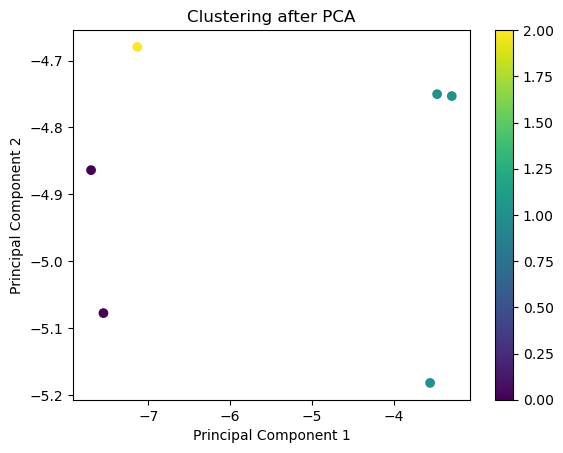

In [13]:
# Gabungkan hasil clustering dengan data PCA
# Memilih kolom tertentu dari DataFrame
cluster_data = pca_predictions.select("pca_features", "prediction").collect()
x = [float(d[0][0]) for d in cluster_data]
y = [float(d[0][1]) for d in cluster_data]
clusters = [int(d[1]) for d in cluster_data]

plt.scatter(x, y, c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering after PCA')
plt.colorbar()
# Menampilkan data dalam DataFrame
plt.show()